In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import graphviz

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('ShootingSplits_HeatCheckTourwTrap.csv')
df.tail(2)

,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,POWER,PATH,DRAW,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,Trapezoid
318,318,2019,741,241,Wofford,SC,92.6,6.3,85.7,4.0,...,71.8,70.7,0.46,1,14.5,23,28,0.227,1.1,0
319,319,2019,740,245,Yale,Ivy,94.3,9.3,82.6,4.1,...,58.4,75.7,0.66,0,3.6,48,53,0.613,-17.3,0


In [3]:
df = df.dropna(axis=1)
df_train = df[df['YEAR'] != 2024]
df_test = df[df['YEAR'] == 2024]
print(df_train.shape)

c = df_train["Trapezoid"]
ctest = df_test["Trapezoid"]
df_train.head(2)

(256, 48)


,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,SEED,ROUND,POWER,PATH,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,POWER-PATH,Trapezoid
64,64,2023,1011,3,Alabama,SEC,88.7,13.0,85.2,5.3,...,1,16,85.2,63.8,2,74.7,4,1,21.4,0
65,65,2023,1010,8,Arizona,P12,90.9,9.4,90.9,5.7,...,2,64,80.9,65.3,0,57.5,7,7,15.6,0


In [4]:
X_train = df_train.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND'],axis=1)
X_test = df_test.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND'],axis=1)
y_train = df_train.WINS
y_test = df_test.WINS
y_test.head(5)

0    0
1    4
2    2
3    0
4    1
Name: WINS, dtype: int64

In [5]:
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [6]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [7]:
dtree.score(X_train,y_train)

0.5703125

In [8]:
dtree_string = export_text(dtree,feature_names = list(X_train.columns),decimals = 1, spacing = 6)
print(dtree_string)

|------ POOL VALUE <= 0.1
|      |------ PATH <= 0.6
|      |      |------ class: 0
|      |------ PATH >  0.6
|      |      |------ class: 0
|------ POOL VALUE >  0.1
|      |------ THREES D SHARE <= 0.3
|      |      |------ class: 1
|      |------ THREES D SHARE >  0.3
|      |      |------ class: 2



In [9]:
cv_results = cross_validate(dtree,X_train,y_train)
acc_valid = cv_results['test_score'].mean()
print('validation accuracy rate',acc_valid)

validation accuracy rate 0.503921568627451


/home/utsisda/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [10]:
dtree.score(X_test,y_test)

0.53125


best alpha = {'max_depth': 2}   valid R2 = 0.193


<AxesSubplot:xlabel='depth'>

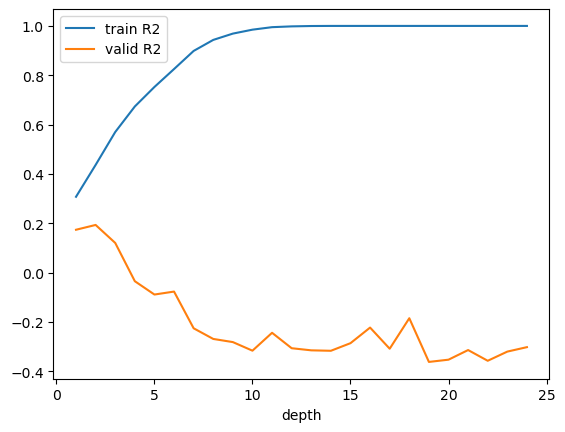

In [11]:
grid = {'max_depth':np.arange(1,25)}

dtree = DecisionTreeRegressor()
dtreeCV = GridSearchCV(dtree,param_grid=grid,return_train_score=True)
dtreeCV.fit(X_train,y_train)

print()
print('best alpha =',dtreeCV.best_params_, '  valid R2 =',dtreeCV.best_score_.round(3))

results = pd.DataFrame()
results['depth']    = grid['max_depth']
results['train R2'] = dtreeCV.cv_results_['mean_train_score']
results['valid R2'] = dtreeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train R2')
results.plot.line(x='depth',y='valid R2',ax=ax1)

grid = {'n_estimators':[10,100,200],'max_depth':np.arange(1,30)}
rf = RandomForestRegressor(n_jobs=-1)
rfCV = GridSearchCV(rf,param_grid=grid,n_jobs=-1)
rfCV.fit(X_train,y_train)
print('best parameter',rfCV.best_params_)
print('validation R2',rfCV.best_score_.round(2))

rf_opt = rfCV.best_estimator_
R2_train = rf_opt.score(X_train,y_train)
R2_test  = rf_opt.score(X_test,y_test)
print('Forest -> train R2 =',R2_train.round(3),'  test R2 =',R2_test.round(3))


## For wins

In [12]:
df = pd.read_csv("Datasets/KenPom Barttorvik.csv")
df

,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,...,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK
0,2024,MAC,17,61,1,1079,2,Akron,14,64,...,276,238,199,19,176,164,47,122,51,249
1,2024,SEC,28,63,3,1078,3,Alabama,4,4,...,13,33,8,156,106,10,314,2,263,7
2,2024,P12,24,63,3,1077,8,Arizona,2,16,...,16,50,37,196,7,195,134,8,14,47
3,2024,SEC,28,64,4,1076,12,Auburn,4,64,...,58,86,76,127,69,59,284,12,8,69
4,2024,B12,7,63,3,1075,14,Baylor,3,32,...,274,31,22,304,34,97,254,15,155,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,2008,BE,8,1,1,5,235,West Virginia,7,16,...,225,18,115,181,61,209,16,22,32,49
1075,2008,SB,26,1,1,4,236,Western Kentucky,12,16,...,111,160,179,55,131,127,214,27,28,203
1076,2008,BSth,10,4,4,3,239,Winthrop,13,64,...,301,231,206,89,236,339,190,170,12,179
1077,2008,B10,6,3,3,2,240,Wisconsin,3,16,...,301,51,35,98,12,118,117,60,2,57


In [13]:
conditions = [
    (df['ROUND'] == 1),
    (df['ROUND'] == 2),
    (df['ROUND'] == 4),
    (df['ROUND'] == 8),
    (df['ROUND'] == 16),
    (df['ROUND'] == 32),
    (df['ROUND'] == 64)
]

values = [6, 5, 4, 3, 2, 1, 0]

# Create a new column based on conditions
df['WINS'] = np.select(conditions, values, default=None)
df.tail(2)

,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,...,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK,WINS
1077,2008,B10,6,3,3,2,240,Wisconsin,3,16,...,51,35,98,12,118,117,60,2,57,2
1078,2008,A10,1,1,1,1,244,Xavier,3,8,...,149,92,63,147,20,86,4,44,85,3


In [14]:
df_train = df[df['YEAR'] != 2024]
df_train = df_train[df_train['YEAR'] >= 2019]
df_train = df_train[df_train['ROUND'] < 68]
print(df_train.shape)
df_test = df[df['YEAR'] == 2024]
df_test = df_test[df_test['ROUND'] != 68]



(256, 104)


In [15]:
X_train = df_train.drop(['TEAM', 'CONF','CONF ID','QUAD NO', 'QUAD ID','TEAM NO','TEAM ID','ROUND','YEAR','ROUND','WINS'], axis=1)
y_train = df_train['WINS']
X_test = df_test.drop(['TEAM', 'CONF','CONF ID','QUAD NO', 'QUAD ID','TEAM NO','TEAM ID','ROUND','YEAR','ROUND','WINS'], axis=1)  
y_test = df_test['WINS']

In [16]:
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [17]:
results = []
TrainR2 = []
TestR2 = []
depth = []
X_train.head(2)
y_train.head(2)

68    2
69    0
Name: WINS, dtype: object

In [18]:
dtree = DecisionTreeClassifier(max_depth=2)

In [20]:
dtree.fit(X_train,y_train.astype('category'))

DecisionTreeClassifier(max_depth=2)

In [21]:
dtree_string = export_text(dtree,feature_names = list(X_train.columns),decimals = 1, spacing = 6)
print(dtree_string)

|------ ELITE SOS <= -0.8
|      |------ EFGD% RANK <= -1.0
|      |      |------ class: 1
|      |------ EFGD% RANK >  -1.0
|      |      |------ class: 0
|------ ELITE SOS >  -0.8
|      |------ KADJ EM <= 0.7
|      |      |------ class: 0
|      |------ KADJ EM >  0.7
|      |      |------ class: 2

